In [1]:
import cv2

import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import numpy as np

In [16]:
from predict_gaze_from_video import *

cpu


In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load a simple face detector
# !pip install retina-face
# !uv add retina-faceb
from retinaface import RetinaFace

In [5]:
%matplotlib inline

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [7]:
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))
print(tf.sysconfig.get_build_info()["cudnn_version"])

GPUs Available: []
9


2025-05-05 15:24:56.156885: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
print(tf.__version__)

2.19.0


In [9]:
# load Gaze-LLE model
model, transform = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitl14_inout')
model.eval()
model.to(device)

Using cache found in /home/wangy79/.cache/torch/hub/fkryan_gazelle_main
Using cache found in /home/wangy79/.cache/torch/hub/facebookresearch_dinov2_main


GazeLLE(
  (backbone): DinoV2Backbone(
    (model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=4096, out_features=10

In [11]:
# video_file = "/Datasets/.Autism_Videos/data/bids/sub-2425/ses-18mo/sub-2425_ses-18mo_measure-CSBS_video.wmv"
video_file = "/Datasets/.Autism_Videos/data/bids/sub-9943/ses-18mo/sub-9943_ses-18mo_measure-CSBS_video.wmv"
vid = cv2.VideoCapture(video_file)

images = []
while True:
    vid.grab()
    retval, image = vid.retrieve()
    if not retval:
        break
    image_pil = convert_frame_to_images(image)
    images.append(image_pil)
vid.release()



In [12]:
len(images)

42646

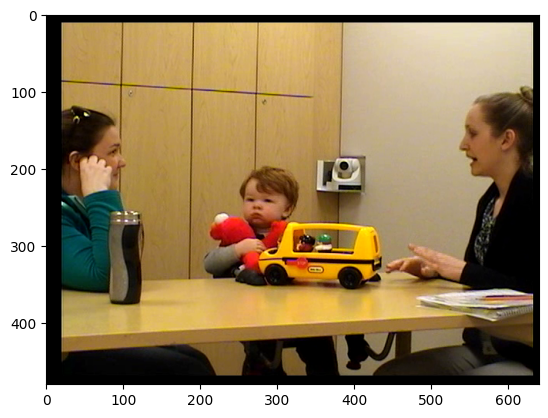

In [13]:
sample_image = images[1000]
plt.imshow(sample_image)

In [14]:
resp = RetinaFace.detect_faces(np.array(images[1000]))
print(resp)
bboxes = [resp[key]['facial_area'] for key in resp.keys()]

{'face_1': {'score': 0.9993828535079956, 'facial_area': [537, 118, 590, 210], 'landmarks': {'right_eye': [546.9043, 154.85881], 'left_eye': [551.99524, 155.28477], 'nose': [537.9914, 172.37628], 'mouth_right': [552.8044, 188.09569], 'mouth_left': [557.7521, 187.01582]}}, 'face_2': {'score': 0.9987300634384155, 'facial_area': [51, 145, 103, 226], 'landmarks': {'right_eye': [86.19635, 180.32384], 'left_eye': [95.6394, 179.34874], 'nose': [102.249374, 193.63402], 'mouth_right': [87.35188, 208.15833], 'mouth_left': [93.79532, 207.98648]}}, 'face_3': {'score': 0.9981557130813599, 'facial_area': [256, 214, 308, 275], 'landmarks': {'right_eye': [265.5072, 240.2595], 'left_eye': [287.82227, 242.07294], 'nose': [271.62604, 249.71115], 'mouth_right': [265.19675, 262.05682], 'mouth_left': [279.9514, 263.6221]}}}


Number of images: 1
Image size: 640 480
[0.44305389]


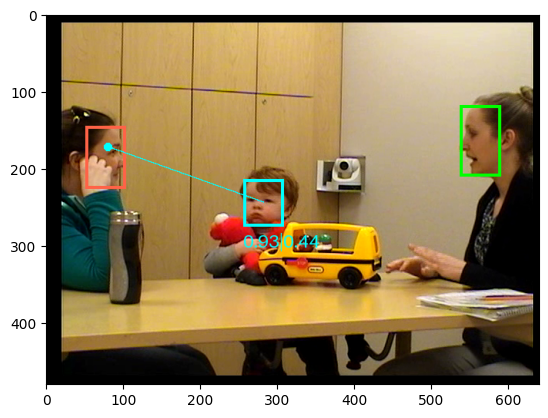

In [18]:
eye_contact_score, overlay = visualize_gaze_in_image(model, transform, [sample_image])
print(eye_contact_score)
plt.imshow(overlay[0])

Number of images: 1
Image size: 640 480
[0.08508024]


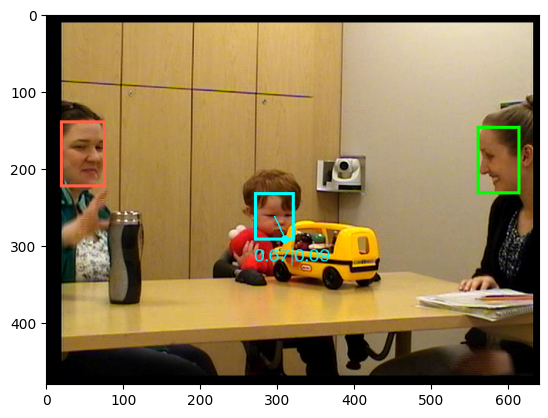

In [19]:
eye_contact_score, overlay = visualize_gaze_in_image(model, transform, [images[2000]])
print(eye_contact_score)
plt.imshow(overlay[0])

Number of images: 1
Image size: 640 480
[0.]


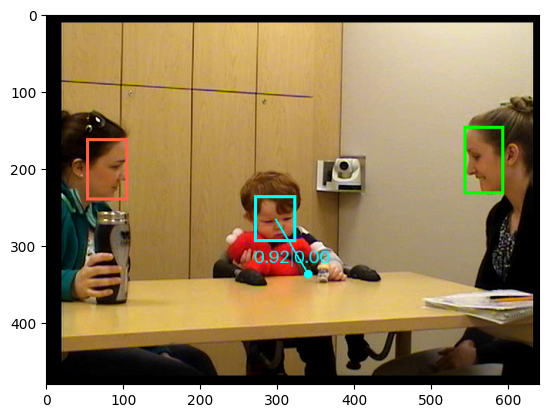

In [20]:
eye_contact_score, overlay = visualize_gaze_in_image(model, transform, [images[3000]])
print(eye_contact_score)
plt.imshow(overlay[0])

In [ ]:
import pandas as pd
results = []
annotation_file = video_file.replace("video.wmv", "coding.xlsx")
anns = pd.read_excel(annotation_file)
gaze_label = code_gaze_label(anns["EYE CONTACT"])
label_len = len(gaze_label) # get rid of the NaN values
### test only first 3 trials
label_len = 2
###
begin_times = anns["Begin Time - ss.msec"][:label_len]
end_times = anns["End Time - ss.msec"][:label_len] 
imgs, trial_tracker = extract_frame_at_time_ranges(video_file, list(zip(begin_times, end_times)))
gaze_scores, overlay_images = visualize_gaze_in_image(model, transform, imgs)
# print(gaze_scores)
# print(gaze_label)
# print(trial_tracker)


In [67]:
images_to_plot = []

assert len(trial_tracker) == len(gaze_scores)
seg_score = np.zeros(label_len)
for i in range(label_len):
    trial_ind = trial_tracker == i
    seg_score[i], j = np.max(gaze_scores[trial_ind]), np.argmax(gaze_scores[trial_ind])
    print(j)
    images_to_plot.append(np.array(overlay_images)[trial_ind][j])
gaze_pred = seg_score > 0.2
    


20
24


In [68]:
seg_score

array([0.1222762 , 0.25649393])

In [69]:
gaze_label = gaze_label[:label_len]

Accuracy: 0.5


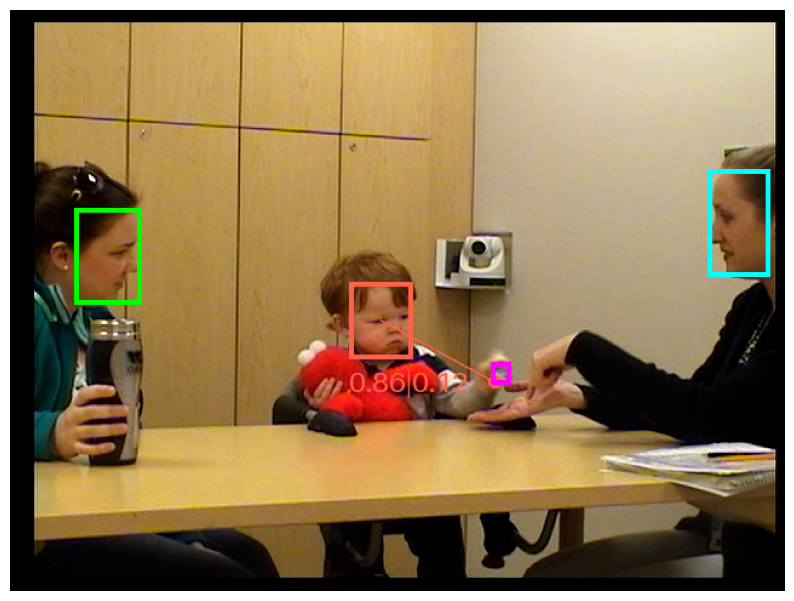

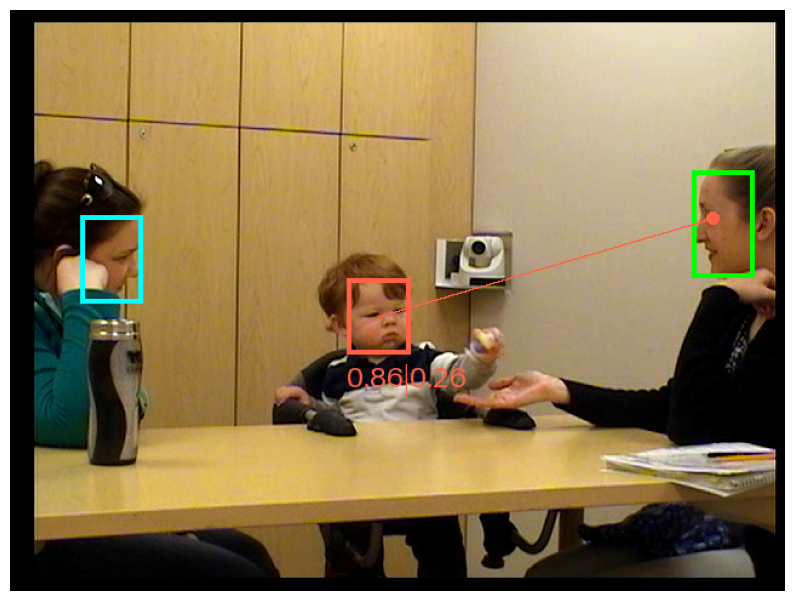

In [70]:
acc = np.mean(gaze_pred == gaze_label)
specificity = np.sum((gaze_pred == 0) & (gaze_label == 0)) / np.sum(gaze_label == 0)
sensitivity = np.sum((gaze_pred == 1) & (gaze_label == 1)) / np.sum(gaze_label == 1)
results.append((os.path.basename(video_file), acc, specificity, sensitivity))
print("Accuracy:", acc)
for i in range(label_len):
    plt.figure(figsize=(10,10))
    plt.imshow(images_to_plot[i])
    plt.axis('off')

94


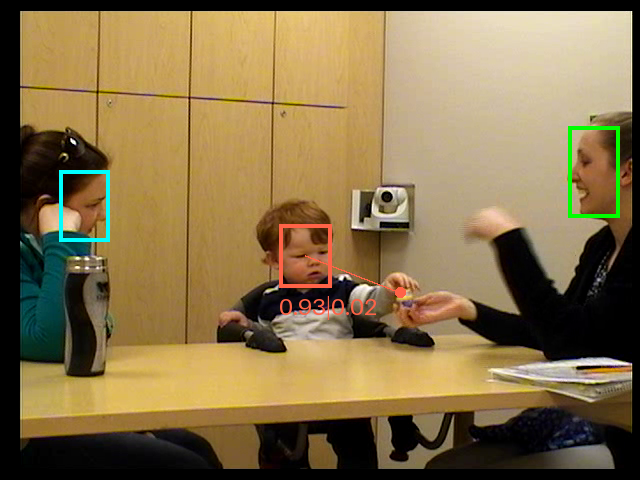

In [65]:
print(len(overlay_images))
overlay_images[90]

In [35]:
gaze_scores

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00072322, 0.        , 0.00098917, 0.00322929, 0.04712486,
       0.03413799, 0.05075288, 0.0743465 , 0.09951509, 0.115378  ,
       0.1222762 , 0.06572468, 0.04933188, 0.02207935, 0.026693  ,
       0.0185493 , 0.01105924, 0.01069896, 0.0187816 , 0.03494399,
       0.03664117, 0.02796626, 0.01421529, 0.01008276, 0.01501941,
       0.02544256, 0.02277933, 0.01485863, 0.01108324, 0.00382821,
       0.00368265, 0.00912568, 0.00616546, 0.01043219, 0.01031055,
       0.00648319, 0.00536709, 0.        , 0.00217097, 0.00759622,
       0.00633992, 0.008465  , 0.01469033, 0.03453772, 0.03560656,
       0.04550836, 0.05301968, 0.06230678, 0.16321516, 0.09736161,
       0.10676653, 0.14601888, 0.18230734, 0.25649393, 0.21130726,
       0.18357202, 0.09778583, 0.12267356, 0.16303722, 0.23742894,
       0.11717116, 0.05072391, 0.10359414, 0.09179248, 0.07642

In [36]:
trial_tracker

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [37]:
gaze_pred

array([False,  True])

In [39]:
gaze_label

array([0, 0])

In [43]:
len(images_to_plot)

2

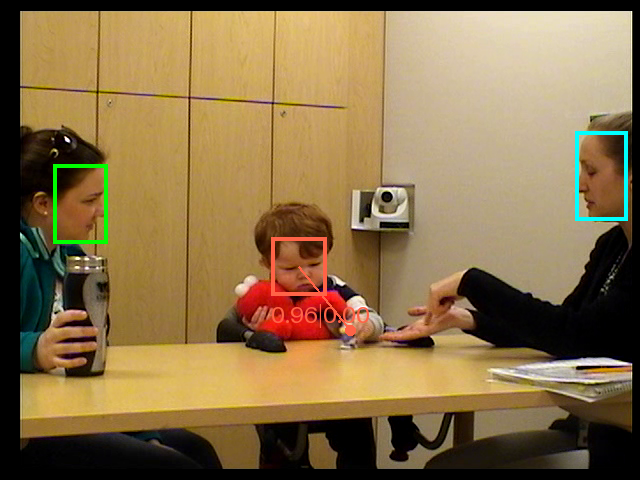

In [44]:
images_to_plot[0]

### Failed cases

Number of images: 1
Image size: 640 480
checking bbox
1
[-1]


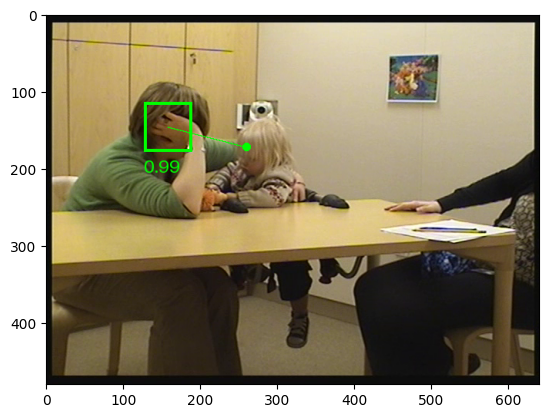

In [27]:
eye_contact_score, overlay = visualize_gaze_in_image(model, transform, [imgs[32]], face_threshold=0.1)
print(eye_contact_score)
plt.imshow(overlay[0])